In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
path = glob('../content/drive/MyDrive/car/annotations/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [ ]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,../content/drive/MyDrive/car/annotations/Cars1...,134,262,128,160
1,../content/drive/MyDrive/car/annotations/Cars0...,226,419,125,173
2,../content/drive/MyDrive/car/annotations/Cars1...,175,214,114,131
3,../content/drive/MyDrive/car/annotations/Cars1...,140,303,5,148
4,../content/drive/MyDrive/car/annotations/Cars1...,66,322,147,199


In [ ]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('../content/drive/MyDrive/car/images',filename_image)
    return filepath_image
getFilename(filename)

'../content/drive/MyDrive/car/images/Cars1.png'

In [ ]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]

['../content/drive/MyDrive/car/images/Cars1.png',
 '../content/drive/MyDrive/car/images/Cars0.png',
 '../content/drive/MyDrive/car/images/Cars100.png',
 '../content/drive/MyDrive/car/images/Cars10.png',
 '../content/drive/MyDrive/car/images/Cars102.png',
 '../content/drive/MyDrive/car/images/Cars106.png',
 '../content/drive/MyDrive/car/images/Cars105.png',
 '../content/drive/MyDrive/car/images/Cars101.png',
 '../content/drive/MyDrive/car/images/Cars104.png',
 '../content/drive/MyDrive/car/images/Cars103.png']


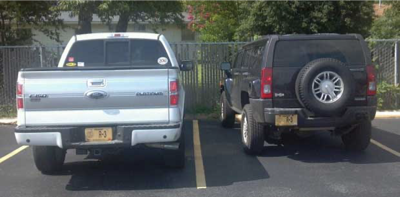

In [ ]:
file_path = image_path[87] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882 
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=1804, x1=2493, y0=1734, y1=1882, xref='x', yref='y',line_color='cyan')

In [ ]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [ ]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [ ]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((346, 224, 224, 3), (87, 224, 224, 3), (346, 4), (87, 4))

In [ ]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [ ]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 111, 111, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                           

In [ ]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=10,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/10
35/35 [==============================] - 395s 11s/step - loss: 0.0350 - val_loss: 0.0329
Epoch 2/10
35/35 [==============================] - 371s 11s/step - loss: 0.0112 - val_loss: 0.0256
Epoch 3/10
35/35 [==============================] - 367s 10s/step - loss: 0.0075 - val_loss: 0.0206
Epoch 4/10
35/35 [==============================] - 366s 10s/step - loss: 0.0044 - val_loss: 0.0354
Epoch 5/10
35/35 [==============================] - 367s 11s/step - loss: 0.0046 - val_loss: 0.0324
Epoch 6/10
35/35 [==============================] - 366s 10s/step - loss: 0.0027 - val_loss: 0.0269
Epoch 7/10
35/35 [==============================] - 367s 10s/step - loss: 0.0023 - val_loss: 0.0252
Epoch 8/10
35/35 [==============================] - 364s 10s/step - loss: 0.0020 - val_loss: 0.0227
Epoch 9/10
35/35 [==============================] - 363s 10s/step - loss: 0.0015 - val_loss: 0.0205
Epoch 10/10
35/35 [==============================] - 368s 10s/step - loss: 0.0016 - val_loss: 0.0163

In [ ]:
!tensorboard --logdir="./content/object_detection"

2022-09-07 14:04:16.044756: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/jax/_src/dispatch.py", line 176, in wait_for_tokens
    @atexit.register
KeyboardInterrupt
^C


In [ ]:
model.save('./content/object_detection.h5')

In [ ]:
# Load model
model = tf.keras.models.load_model('/content/content/object_detection.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [ ]:
path = '/content/drive/MyDrive/car/images/Cars413.png'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)

Height of the image = 256
Width of the image = 400



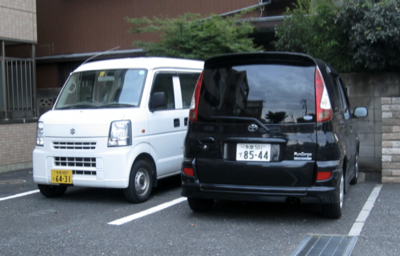

In [ ]:
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 13 - TEST Image')

In [ ]:
image_arr_224.shape

(224, 224, 3)

In [ ]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [ ]:
coords = model.predict(test_arr)
coords

array([[0.43848833, 0.48741186, 0.5775828 , 0.65864503]], dtype=float32)

In [ ]:
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[175.39533377, 194.96474266, 147.8611908 , 168.61312866]])

In [ ]:
coords = coords.astype(np.int32)
coords

array([[175, 194, 147, 168]], dtype=int32)

In [ ]:
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(175, 147) (194, 168)



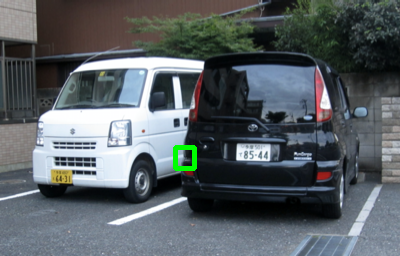

In [ ]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

(267, 242) (419, 283)



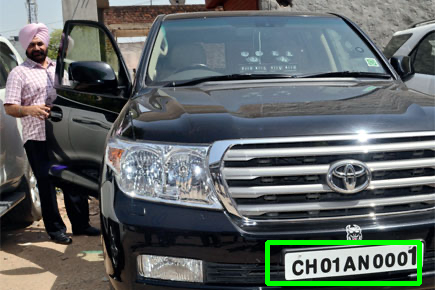

In [ ]:
# Create pipeline
path = '/content/drive/MyDrive/car/images/Cars370.png'
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')


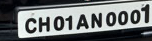

In [ ]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 15 Cropped image')


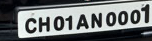

In [ ]:
fig